In [1]:
! pip install underthesea

     |████████████████████████████████| 7.5 MB 4.3 MB/s 
     |████████████████████████████████| 743 kB 44.4 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 2.8 MB 33.3 MB/s 
     |████████████████████████████████| 235 kB 38.6 MB/s 
     |████████████████████████████████| 636 kB 49.2 MB/s 
     |████████████████████████████████| 3.3 MB 33.2 MB/s 
     |████████████████████████████████| 895 kB 52.7 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=19dc0413a2b6ad6f35c2df0b4d9fa73040f1255b569a9c70ad09decf5dedbdef
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Preprocessing Data

In [2]:
from collections import Counter
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import pickle
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
# except ValueError:
#     tpu = None
# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy()

In [5]:
MAX_LENGTH = 80

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Chatbot/vietnamese-chatbot/final_data/data.csv')
df = df.drop('topic', axis=1)
df.head()

,question,answer
0,bạn thuê trọ bao_nhiêu tiền,mình thuê khoảng 3 tr một tháng
1,nhà bạn có bao_nhiêu người vậy,nhà mình có 7 người
2,nhà_trọ bạn ở phú_mỹ_hưng phải không,không nhà mình ở thảo_điền
3,bạn ơi cho t hỏi chỗ trọ lúc trước bạn ở giá_c...,giá hơi mắc nên mình đã chuyển đi rồi đó bạn 5...
4,bạn ơi lúc trước mình có nghe bạn kể rằng bạn ...,à mình chuyển trọ để gần nơi đi làm ở quận 7 đ...


In [7]:
questions = df['question'].to_list()
answers = df['answer'].to_list()

In [8]:
print(len(questions))

5767


In [9]:
from underthesea import word_tokenize
import string 
def preprocess_sentence(text):
    text = ''.join([i for i in text if i not in string.punctuation])
    return word_tokenize(text.strip(), format='text').lower()

In [10]:
preprocess_sentence('Tên của tôi là Phạm Trung Sơn')

'tên của tôi là phạm_trung_sơn'

In [11]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size = 1000
)

INFO:absl:SubwordTextEncoder build: trying min_token_count 2225
INFO:absl:SubwordTextEncoder build: trying min_token_count 1112
INFO:absl:SubwordTextEncoder build: trying min_token_count 556
INFO:absl:SubwordTextEncoder build: trying min_token_count 278
INFO:absl:SubwordTextEncoder build: trying min_token_count 139
INFO:absl:SubwordTextEncoder build: trying min_token_count 69
INFO:absl:SubwordTextEncoder build: trying min_token_count 34
INFO:absl:SubwordTextEncoder build: trying min_token_count 51
INFO:absl:SubwordTextEncoder build: trying min_token_count 42
INFO:absl:SubwordTextEncoder build: trying min_token_count 46
INFO:absl:SubwordTextEncoder build: trying min_token_count 48


In [12]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [13]:
print('Sample tokenizer questions: {}'.format(tokenizer.encode(questions[200])))

Sample tokenizer questions: [247, 269, 2, 57, 88, 263, 44, 839, 533]


In [14]:
#mã hóa, lọc và đệm câu(tokenize, filter, pad sentence)
MAX_LENGTH = 80
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs = []
    tokenized_outputs = []
    for (input_sent, output_sent) in zip(inputs, outputs):
        # mã hóa câu
        input_sent = START_TOKEN + tokenizer.encode(input_sent) + END_TOKEN
        output_sent = START_TOKEN + tokenizer.encode(output_sent) + END_TOKEN
        # kiểm tra câu mã hóa với chiều dài qui định
        if len(input_sent) <= MAX_LENGTH and len(output_sent) <= MAX_LENGTH:
            tokenized_inputs.append(input_sent)
            tokenized_outputs.append(output_sent)

    # pad sentence
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post'
    )
    return tokenized_inputs, tokenized_outputs

In [15]:
questions, answers = tokenize_and_filter(questions, answers)

In [16]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of Sample questions:{}'.format(len(questions)))
print('Number of Sample answers: {}'.format(len(answers)))

Vocab size: 998
Number of Sample questions:5744
Number of Sample answers: 5744


In [17]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, : -1]
    },
    {
        'outputs': answers[:, 1: ]
    },
))
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 2000
BUFFER_SIZE = 1000
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(AUTO)

In [18]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 80), dec_inputs: (None, 79)}, {outputs: (None, 79)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

In [19]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    if mask is not None:
        logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'num_heads': self.num_heads,
            'd_model': self.d_model,
        })
        return config 
    
    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(lambda inputs: tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth)
        ))(inputs)
        return tf.keras.layers.Lambda(lambda inputs: tf.transpose(
            inputs, perm=[0, 2, 1, 3]))(inputs)

    def call(self, inputs, **kwargs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        #linear layer
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        #split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        #scale dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.transpose(
            scaled_attention, perm=[0, 2, 1, 3]
        ))(scaled_attention)

        #concatention of heads
        concat_attention = tf.keras.layers.Lambda(lambda scaled_attention: tf.reshape(
            scaled_attention, (batch_size, -1, self.d_model)
        ))(scaled_attention)

        #final linear
        outputs = self.dense(concat_attention)

        return outputs

In [21]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [22]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [23]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [24]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [25]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model,

        })
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # hàm sin
        sines = tf.math.sin(angle_rads[:, 0::2])
        # hàm cosin 
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs, **kwargs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [26]:
sample_pos_encoding = PositionalEncoding(50, 512)

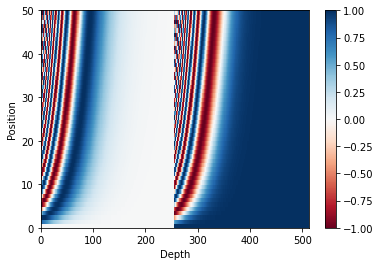

In [27]:
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [28]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [29]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [30]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [31]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32)))(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [32]:
sample_decoder = decoder( vocab_size=8192, num_layers=2, units=512, d_model=128,
                         num_heads=4, dropout=0.3, name="sample_decoder")

#tf.keras.utils.plot_model( sample_decoder, to_file='decoder.png', show_shapes=True)

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [34]:
sample_transformer = transformer(vocab_size=8192, num_layers=2, units=256,
                                 d_model=128, num_heads=4,
                                 dropout=0.3, name="sample_transformer")

#tf.keras.utils.plot_model( sample_transformer, to_file='transformer.png', show_shapes=True)

In [35]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.multiply(tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2))

Text(0.5, 0, 'Train Step')

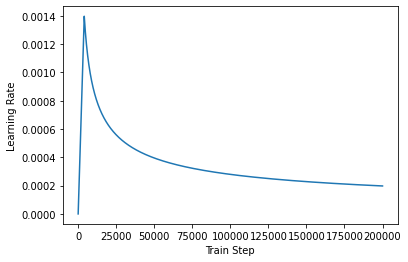

In [37]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate") 
plt.xlabel("Train Step")

In [38]:

def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


In [39]:
tf.keras.backend.clear_session()

# initialize and compile model within strategy scope
NUM_LAYERS = 3
D_MODEL = 128
NUM_HEADS = 4
UNITS = 2
DROPOUT = 0.1


model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [40]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [41]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 128)    329350      inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [54]:
EPOCHS = 200
#model.fit(dataset, epochs=EPOCHS, batch_size=5)

Epoch 1/200
3/3 [==============================] - 7s 2s/step - loss: 0.0768 - accuracy: 0.1404
Epoch 2/200
3/3 [==============================] - 7s 2s/step - loss: 0.0758 - accuracy: 0.1408
Epoch 3/200
3/3 [==============================] - 7s 2s/step - loss: 0.0757 - accuracy: 0.1407
Epoch 4/200
3/3 [==============================] - 7s 2s/step - loss: 0.0772 - accuracy: 0.1403
Epoch 5/200
3/3 [==============================] - 7s 2s/step - loss: 0.0742 - accuracy: 0.1410
Epoch 6/200
3/3 [==============================] - 7s 2s/step - loss: 0.0746 - accuracy: 0.1413
Epoch 7/200
3/3 [==============================] - 7s 2s/step - loss: 0.0739 - accuracy: 0.1414
Epoch 8/200
3/3 [==============================] - 7s 2s/step - loss: 0.0731 - accuracy: 0.1416
Epoch 9/200
3/3 [==============================] - 7s 2s/step - loss: 0.0730 - accuracy: 0.1415
Epoch 10/200
3/3 [==============================] - 7s 2s/step - loss: 0.0727 - accuracy: 0.1416
Epoch 11/200
3/3 [=====================

In [55]:
#model.save_weights('/content/drive/MyDrive/Wisdom Company/Transformers/transformer_chatbot_gpu.h5')

In [58]:
model.load_weights('/content/drive/MyDrive/Wisdom Company/Transformers/transformer_chatbot_gpu.h5')

In [59]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

def predict(sentence):
    predict = evaluate(sentence)
    predicted_sentence = tokenizer.decode([i for i in predict if i < tokenizer.vocab_size])
    return print('Bot: {}'.format(predicted_sentence.replace('\&undsc', ' ')))
    

In [60]:
while (1):
    question = input("Question: ")
    if question == 'quit':
        break
    sentence = predict(question)


Question: mày tên là gì
Bot: vũ
Question: mày ăn cơm chưa
Bot: tao ăn cơm gòi
Question: quit


In [61]:
print(tf.__version__)

2.6.0
